<a href="https://colab.research.google.com/github/ElenaShargina/nnetworks/blob/main/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B0_ADAM_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BD%D1%8B%D0%B9_%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Реализована работа алгоритма ADAM на примере трёхслойной нейронной сети.

Функция активация - сигмоидальная.
Корректировка весов происходит с помощью стохастического градиентного спуска (модификация ADAM).



# Подготовка данных

In [ ]:
# Импортируем необходимые пакеты
import numpy as np
import matplotlib.pyplot as plt
# Зафиксируем генератор случайных чисел
from numpy.random import seed
seed(2020)

In [ ]:
# количество элементов в обучающей выборке
m = 17
# величина шага
h = 0.7
# количество эпох без улучшения точности, после которого остановим поиск
patience = 10
# точность
eps = 0.000001
eps_func = 0.06

# обучающая выборка
dataX = np.array([
    [0.1, 0.2, 0.3, 0.4],
    [0.2, 0.3, 0.4, 0.5],
    [0.3, 0.4, 0.5, 0.6],
    [0.4, 0.5, 0.6, 0.7],
    [0.5, 0.6, 0.7, 0.8],
    [0.6, 0.7, 0.8, 0.9],
    [0.7, 0.8, 0.9, 0],
    [0.8, 0.9, 0, -0.1],
    [0.9, 0, -0.1, -0.2],
    [0, -0.1, -0.2, -0.3],
    [-0.1, -0.2, -0.3, -0.4],
    [-0.2, -0.3, -0.4, -0.5],
    [-0.3, -0.4, -0.5, -0.6],
    [-0.4, -0.5, -0.6, -0.7],
    [-0.5, -0.6, -0.7, -0.8],
    [-0.6, -0.7, -0.8, -0.9],
    [-0.7, -0.8, -0.9, 0]
])
# правильные ответы к обучающей выборке
dataY = np.array([1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 0, -1, -1.2, -1.3, -1.4, -1.5, -1.6, -1.7])


В сети будет три слоя:

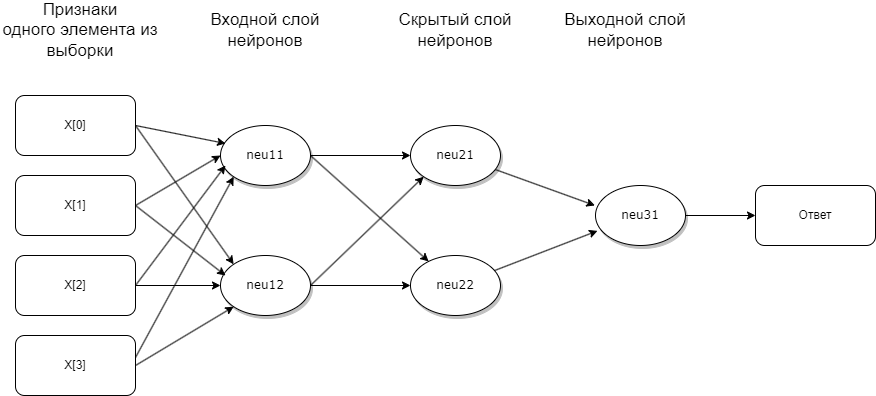

Задаем первичные веса - какие-то маленькие значения.

In [ ]:
weights1 = np.array([
    [0.01,0.02,0.03,0.04],
    [0.05,0.06,0.07,0.08]
                     ])

weights2 = np.array([
    [-0.01,-0.02],
    [-0.03,-0.04]
])
weights3 = np.array([[-0.05,-0.06]])

# Задание функций

Функция активации - сигмоидная

$\phi(x) = \frac{1}{1+e^{-x}}$

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Производная от сигмоидной функции

$ \phi^\prime(x) = \frac{e^{-x}}{(1+e^{-x})^2}$

In [ ]:
def diffsig(x): 
    return np.exp(-x)/(1+np.exp(-x))**2

Для получения результатов работы первых двух слоёв вводим функцию активации их нейронов.

In [ ]:
def neuro_activate(weights,x):
    return sigmoid(np.sum(weights*x))

# производная фукции работы нейрона в первых двух слоях
def diff_neuro(weights,x):
    return diffsig(np.sum(weights*x)) 

Для получения результата работы выходного слоя вводим функцию простого суммирования без активации.

In [ ]:
def neuro_sum(weights,x):
    return np.sum(weights*x)

Функция получения ответа от сети по элементу x с текущими весами weight1,weight2,weight3


In [ ]:
def answer(x):
    # Значения первого слоя
    neu11 = neuro_activate(weights1[0], x)
    neu12 = neuro_activate(weights1[1], x)

    # Значения второго слоя
    neu21 = neuro_activate(weights2[0], np.array([neu11, neu12]))
    neu22 = neuro_activate(weights2[1], np.array([neu11, neu12]))

    # Значение выхода сети
    neu31 = neuro_sum(weights3, np.array([neu21, neu22]))

    return neu31.round(3)

Функция потерь (MSE)

$E(w_1,...,w_n)=\frac{\sum_{i=1}^m{(y-\phi(\sum_{i=1}^n{w_ix_i}))^2}}{m}$

In [ ]:
def loss_func(weights1,weights2,weights3, dataY, dataX):
    E = 0
    for i in range(m):
        E += (dataY[i] - answer(dataX[i]))**2
        
    E = E/len(dataY)
    return E

# Работа алгоритма

Стохастический градиентный спуск - после анализа каждого элемента выборки будем менять веса модели. 
Для этого:

 $y$ - правильный ответ

  $y_{i,j}$ - ответ j-того нейрона на i-м слое сети 

  $w_{k,i,j}$ - j-й вес i-того нейрона на k-м слое сети
  
  $x_i$ - признак элемента входящей выборки, стоящий на i-м месте
  1. Посчитаем производные функции ошибки на выходном (3) слое
    
  $\frac{\partial E}{\partial w_{3,i}} = 2(y - y_3)y_{2,i}$

  2. Посчитаем производные функции ошибки на скрытом (2) слое

  $\frac{\partial E}{\partial w_{2,i,j}} = 2(y-y_{3})w_{3,i}\frac{\text{d}\phi(y_2)}{\text{d}w_{2,i}}y_{2,j}$

  3. Посчитаем производные функции ошибки на входном (1) слое

  $\frac{\partial E}{\partial w_{1,i,j}} = 2(y-y_{3})(w_{3,1}\frac{\partial \phi(y_2)}{\partial w_{2,1}}w_{2,1,i}+w_{3,2}\frac{\partial \phi(y_2)}{\partial w_{2,2}}w_{2,2,i})\frac{\partial \phi(x_j)}{\partial w_{1,j}}x_{j}$

  4. Корректируем инерцию для каждого веса

  $\gamma $ - влияние инерции, задано в начале алгоритма (gammav)

  $v_{k,i,j}$ - инерция j-го веса i-го нейрона на k-м слое 

  $E_{k,i,j}$ - производная функции ошибки по j-му весу i-ого нейрона на k-м слое 

  $t$ - итерация алгоритма

  $v\prime_{k,i,j} = \frac{\gamma v_{k,i,j}+( 1-\gamma E_{k,i,j})}{1-\gamma^t}$

  5. Корректируем масштабирование для каждого веса

  $\delta$ - влияение масштабирования, задано в начале алгоритма (gammag)

  $g_{k,i,j}$ - масштабирование j-го веса i-го нейрона на k-м слое

  $g\prime_{k,i,j} = \frac{\delta g_{k,i,j}+(1-\delta)E_{k,i,j}^2}{1-\delta^t}$

  6. Корректируем веса

  $w_{k,i,j}$ - j-й вес i-ого нейрона на k-м слое

  $h$ - шаг алгоритма, задан в начале скрипта  (h)

  $e$ - точность, заданная в начале скрипта (eps)

  $w\prime_{k,i,j} = w_{k,i,j} + h \frac{v_{k,i,j}}{\sqrt{(g_{k,i,j}+eps)}}$

In [ ]:
# счетчик итераций без улучшений, 
# заканчиваем цикл, если он достигнет параметра patience
failure_stop = 0
index = np.arange(m)
# счетчик итераций
t = 0
# Список для запоминания функции ошибки
E = list()
# Задаем влияние инерции
gammav = 0.2
# Задаем влияние масштабирования
gammag = 0.2
# Инициализируем инерцию
v1 = np.full((2,4),0.01)
v2 = np.full((2,2),0.01)
v3 = np.array([[0.01,0.01]])
# Инициализируем масштабирование
g1 = np.full((2,4),0.02)
g2 = np.full((2,2),0.02)
g3 = np.array([[0.02,0.02]])

In [ ]:
# Производные для весов входного слоя
diffEw1 = np.empty([2,4])
# Производные для весов скрытого слоя
diffEw2 = np.empty([2,2])
# Производные для весов выходного слоя
diffEw3 = np.empty([2,2])

In [ ]:
# функция для коррекции инерции
def v_correct(v, diffE, gammav, t):
  return (gammav * v + (1 - gammav) * diffE) / (1 - gammav**t)

# функция для коррекции масштабирования
def g_correct(g,diffE,gammag,t):
  return (gammag * g + (1 - gammag) * diffE**2)/ (1 - gammag**t)

# функция корректировки веса
def w_correct(w,h,v,g):
  return w + h*v/ np.sqrt(g + eps)

In [ ]:
for k in range(4000):
    # перемешиваем порядок просмотра выборки
    np.random.shuffle(index)
    
    # если идет не первая итерация, то запоминаем предыдущее значение функции ошибки
    if k>0:
      loss_old = loss_new

    for i in index:
        # Посчитаем значения на выходах нейронов для текущего элемента обучающей выборки
        # не пользуемся функцией answer, потому что будут нужны промежуточные результаты
        # Входного слоя
        neu_in = np.array([
            neuro_activate(weights1[0],dataX[i]),
            neuro_activate(weights1[1], dataX[i])
        ])

        # Скрытого слоя
        neu_deep = np.array([
            neuro_activate(weights2[0],neu_in),
            neuro_activate(weights2[1],neu_in)
        ])

        # Выходного слоя
        neu_out = neuro_sum(weights3,neu_deep)

        # Рассчитаем ошибку ответа сети
        delta = dataY[i] - neu_out

        # Посчитаем значение градиента функции потерь, используя обратное распространение ошибки delta
        # Производные для весов выходного слоя
        diffEw3 = 2 * delta * neu_deep

        # Производные для весов скрытого слоя
        for neuron in np.arange(2):
            for weight in np.arange(2):
                diffEw2[neuron][weight] = 2 * delta*weights3[0][neuron] *diff_neuro(weights2[neuron], neu_in)* neu_in[weight]

        # Производные для весов входного слоя
        for neuron in np.arange(2):
            for weight in np.arange(4):
                diffEw1[neuron][weight] = 2 * delta * (
                        weights3[0][0] * diff_neuro(weights2[0], neu_in) * weights2[0][neuron] +
                        weights3[0][1] * diff_neuro(weights2[1], neu_in) * weights2[1][neuron]
                ) * diff_neuro(weights1[neuron], dataX[i]) * dataX[i][weight]

        # Корректируем инерцию
        v1[0] = v_correct(v1[0], diffEw1[0], gammav, t+1)
        v1[1] = v_correct(v1[1], diffEw1[1], gammav, t+1)
        v2[0] = v_correct(v2[0], diffEw2[0], gammav, t+1)
        v2[0] = v_correct(v2[0], diffEw2[1], gammav, t+1)
        v3[0] = v_correct(v3[0], diffEw3, gammav, t+1)

        #Корректируем масштабирование
        g1[0] = g_correct(g1[0],diffEw1[0],gammag,t+1)
        g1[1] = g_correct(g1[1],diffEw1[1],gammag,t+1)
        g2[0] = g_correct(g2[0],diffEw2[0],gammag,t+1)
        g2[1] = g_correct(g2[1],diffEw2[1],gammag,t+1)
        g3[0] = g_correct(g3[0],diffEw3,gammag,t+1)

        #Корректируем веса
        #Веса нейронов входного слоя
        weights1[0] = w_correct(weights1[0], h, v1[0],g1[0])
        weights1[1] = w_correct(weights1[1], h, v1[1],g1[1])
        weights2[0] = w_correct(weights2[0], h, v2[0],g2[0])
        weights2[1] = w_correct(weights2[1], h, v2[1],g2[1])
        weights3[0] = w_correct(weights3[0], h, v3[0],g3[0])

        t += 1

    # Вычисляем новое значение функции ошибки
    loss_new = loss_func(weights1,weights2,weights3, dataY, dataX)
    E.append(loss_new)

    # Если итерация не первая, то проверяем, улучшилась ли точность
    if k>0 and (abs(loss_new - loss_old) < eps):
        failure_stop += 1
    else:
        failure_stop = 0

    if loss_new < eps_func:
        print(k + 1, 'я итерация. E = ',
              round(loss_new, 6))
        break
    if failure_stop == patience:
        break
    else:
        print(k + 1, 'я итерация. E = ',
              round(loss_new, 6))

1 я итерация. E =  2.590136
2 я итерация. E =  0.415053
3 я итерация. E =  0.452473
4 я итерация. E =  0.381631
5 я итерация. E =  0.118922
6 я итерация. E =  0.121628
7 я итерация. E =  0.408114
8 я итерация. E =  0.089374
9 я итерация. E =  0.198513
10 я итерация. E =  0.20592
11 я итерация. E =  0.340722
12 я итерация. E =  0.476431
13 я итерация. E =  0.105902
14 я итерация. E =  0.281608
15 я итерация. E =  0.102355
16 я итерация. E =  0.205513
17 я итерация. E =  0.568477
18 я итерация. E =  0.209498
19 я итерация. E =  0.769154
20 я итерация. E =  0.117235
21 я итерация. E =  0.163831
22 я итерация. E =  0.063975
23 я итерация. E =  0.082166
24 я итерация. E =  0.100725
25 я итерация. E =  0.284224
26 я итерация. E =  0.50274
27 я итерация. E =  0.85627
28 я итерация. E =  0.381791
29 я итерация. E =  0.452101
30 я итерация. E =  0.514096
31 я итерация. E =  0.145817
32 я итерация. E =  0.181296
33 я итерация. E =  1.062442
34 я итерация. E =  0.17889
35 я итерация. E =  0.12340

In [ ]:
print(f'Алгоритм проработал {k+1} итераций.')
print('Значение функции ошибки: E = ', loss_new)
print(f'Найденные веса: {weights1} {weights2} {weights3}')

Алгоритм проработал 68 итераций.
Значение функции ошибки: E =  0.05539400000000002
Найденные веса: [[-37.38217007  -1.84352275   0.74874471   3.6388995 ]
 [-35.7834175   -1.99321473   0.49781734   3.23619296]] [[-2.13892386e+00 -5.59424884e-02]
 [ 7.86141157e+03  7.86069084e+03]] [[ 5.48377877 -1.83457381]]


График изменения функции ошибки

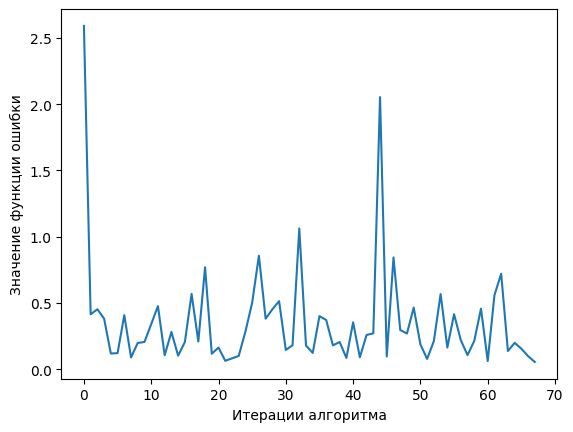

In [ ]:
plt.plot(E)
plt.xlabel('Итерации алгоритма')
plt.ylabel('Значение функции ошибки')
plt.show()

# Проверка работы алгоритма на обучающей выборке. 


In [ ]:
model_answers = np.empty([dataY.size]) 
for i in range(dataY.size):
    model_answers[i] = answer(dataX[i])
print(model_answers)
print(dataY)

[ 0.664  0.899  1.287  1.805  1.824  1.825  1.825  1.825  1.825  0.149
 -1.191 -1.282 -1.285 -1.285 -1.285 -1.285 -1.285]
[ 1.   1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  0.  -1.  -1.2 -1.3 -1.4
 -1.5 -1.6 -1.7]


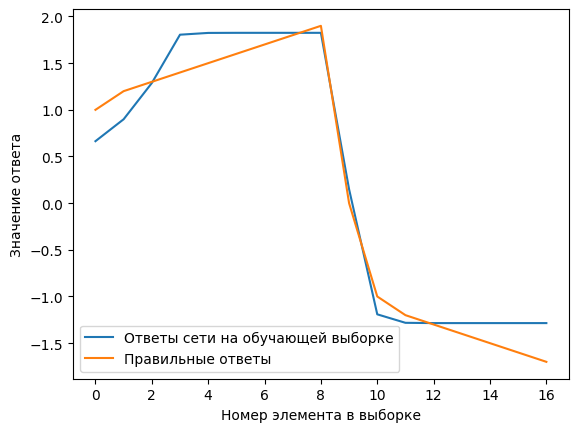

In [ ]:
plt.plot(model_answers, label='Ответы сети на обучающей выборке')
plt.plot(dataY, label='Правильные ответы')
plt.xlabel('Номер элемента в выборке')
plt.ylabel('Значение ответа')
plt.legend()
plt.show()
